# RNN for Time Series

### Import Libraries

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

## Data

Release: Advance Monthly Sales for Retail and Food Services  
Units:  Millions of Dollars, Not Seasonally Adjusted

Frequency:  Monthly

The value for the most recent month is an advance estimate that is based on data from a subsample of firms from the larger Monthly Retail Trade Survey. The advance estimate will be superseded in following months by revised estimates derived from the larger Monthly Retail Trade Survey. The associated series from the Monthly Retail Trade Survey is available at https://fred.stlouisfed.org/series/MRTSSM448USN

Information about the Advance Monthly Retail Sales Survey can be found on the Census website at https://www.census.gov/retail/marts/about_the_surveys.html

Suggested Citation:
U.S. Census Bureau, Advance Retail Sales: Clothing and Clothing Accessory Stores [RSCCASN], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/RSCCASN, November 16, 2019.

https://fred.stlouisfed.org/series/RSCCASN

In [8]:
df = pd.read_csv('DATA/RSCCASN.csv')

In [9]:
df.head()

,DATE,RSCCASN
0,1992-01-01,6938
1,1992-02-01,7524
2,1992-03-01,8475
3,1992-04-01,9401
4,1992-05-01,9558


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334 entries, 0 to 333
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   DATE     334 non-null    object
 1   RSCCASN  334 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.3+ KB


In [12]:
df = pd.read_csv('DATA/RSCCASN.csv',index_col='DATE',parse_dates=True)

In [13]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   RSCCASN  334 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


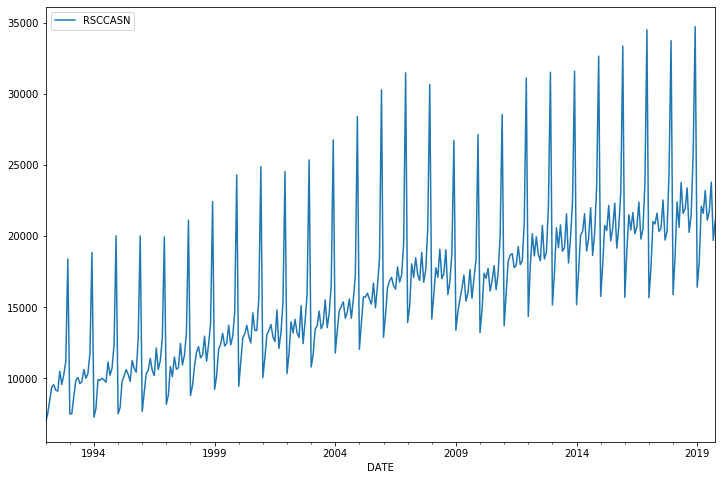

In [15]:
df.plot(figsize=(12, 8))

### Train Test Split

In [17]:
len(df)

334

**Data is monthly, let's forecast 1.5 years into the future.**

In [18]:
len(df)- 18

316

In [19]:
test_size = 18

In [21]:
test_index = len(df)- test_size
test_index

316

In [23]:
train = df.iloc[:test_index]
test = df.iloc[test_index:]

In [24]:
print("train:", train.shape)
print("test:", test.shape)

train: (316, 1)
test: (18, 1)


In [25]:
train

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2017-12-01,33720
2018-01-01,15881
2018-02-01,18585


In [26]:
test

,RSCCASN
DATE,
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919
2018-08-01,23381
2018-09-01,20260
2018-10-01,21473
2018-11-01,25831
2018-12-01,34706
2019-01-01,16410


### Scale Data

In [28]:
from sklearn.preprocessing import MinMaxScaler

In [31]:
scaler = MinMaxScaler()

In [32]:
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [33]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [35]:
scaled_train[:10]

array([[0.        ],
       [0.02127505],
       [0.05580163],
       [0.08942056],
       [0.09512053],
       [0.08146965],
       [0.07860151],
       [0.12979233],
       [0.09566512],
       [0.1203892 ]])

In [36]:
scaled_test[:10]

array([[0.61087714],
       [0.53191258],
       [0.54389341],
       [0.59697212],
       [0.4836625 ],
       [0.52770113],
       [0.68592071],
       [1.00813244],
       [0.34388615],
       [0.40647691]])

### Time Series Generator

In [37]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [58]:
# Let's redefine to get 12 months back and then predict the next month out
length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [39]:
# What does the first batch look like?
X,y = generator[0]

In [40]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.         0.02127505 0.05580163 0.08942056 0.09512053 0.08146965
 0.07860151 0.12979233 0.09566512 0.1203892  0.15426227 0.41595266]
Predict this y: 
 [[0.02047633]]


### Create the Model

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [42]:
# only using one feature in our time series
n_features = 1

In [43]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


### EarlyStopping and creating a Validation Generator

NOTE: The scaled_test dataset size MUST be greater than your length chosen for your batches. Review video for more info on this.

In [45]:
from tensorflow.keras.callbacks import EarlyStopping

In [46]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [47]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

In [53]:
# fit model
model.fit_generator(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20
304/304 [==============================] - 19s 64ms/step - loss: 0.0038 - val_loss: 3.5734e-04
Epoch 2/20
304/304 [==============================] - 17s 56ms/step - loss: 0.0024 - val_loss: 3.9797e-04
Epoch 3/20
304/304 [==============================] - 17s 56ms/step - loss: 0.0021 - val_loss: 2.1914e-04
Epoch 4/20
304/304 [==============================] - 17s 56ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 5/20
304/304 [==============================] - 17s 56ms/step - loss: 0.0017 - val_loss: 0.0031


In [54]:
losses = pd.DataFrame(model.history.history)

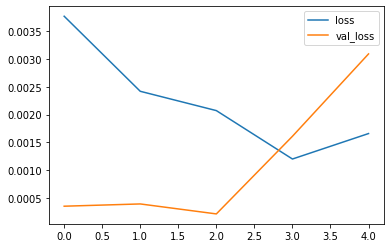

In [55]:
losses.plot()

### Evaluate on Test Data

In [56]:
first_eval_batch = scaled_train[-length:]

In [59]:
first_eval_batch = first_eval_batch.reshape((1, length, n_features))

In [60]:
first_eval_batch.shape

(1, 12, 1)

In [61]:
model.predict(first_eval_batch)

array([[0.57536876]], dtype=float32)

In [62]:
scaled_test[0]

array([0.61087714])

Now let's put this logic in a for loop to predict into the future for the entire test range.

In [63]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

### Inverse Transformations and Compare

In [64]:
true_predictions = scaler.inverse_transform(test_predictions)

In [65]:
# IGNORE WARNINGS
test['Predictions'] = true_predictions

E:\Anaconda Program Data\Program Data\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [66]:
test

,RSCCASN,Predictions
DATE,,
2018-05-01,23764,22785.957181
2018-06-01,21589,21506.299807
2018-07-01,21919,21720.471064
2018-08-01,23381,23669.264831
2018-09-01,20260,20903.675645
2018-10-01,21473,21544.816912
2018-11-01,25831,25849.762106
2018-12-01,34706,36461.130030
2019-01-01,16410,17145.056531


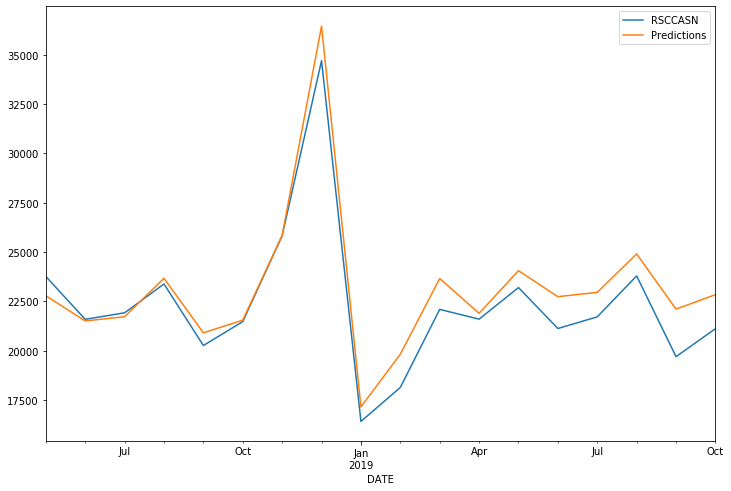

In [67]:
test.plot(figsize=(12,8))

### Retrain and Forecasting

In [68]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [69]:
length = 12 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [70]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


# fit model
model.fit_generator(generator,epochs=8)

Epoch 1/8
322/322 [==============================] - 18s 57ms/step - loss: 0.0242
Epoch 2/8
322/322 [==============================] - 17s 54ms/step - loss: 0.0154
Epoch 3/8
322/322 [==============================] - 18s 57ms/step - loss: 0.0077
Epoch 4/8
322/322 [==============================] - 18s 56ms/step - loss: 0.0037
Epoch 5/8
322/322 [==============================] - 18s 54ms/step - loss: 0.0032
Epoch 6/8
322/322 [==============================] - 19s 60ms/step - loss: 0.0034
Epoch 7/8
322/322 [==============================] - 18s 57ms/step - loss: 0.0017
Epoch 8/8
322/322 [==============================] - 18s 57ms/step - loss: 0.0014


In [72]:
losses = pd.DataFrame(model.history.history)

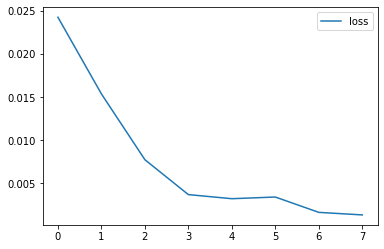

In [73]:
losses.plot()

In [74]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [75]:
forecast = scaler.inverse_transform(forecast)

In [76]:
forecast

array([[26027.56202555],
       [37195.10078526],
       [15722.38300204],
       [17626.9504776 ],
       [21580.78437805],
       [21186.43758917],
       [22847.69520235],
       [20902.15702629],
       [21517.61639214],
       [23651.77690601],
       [19765.47640562],
       [21267.56468201]])

In [78]:
df

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


### Creating new timestamp index with pandas.

In [83]:
forecast_index = pd.date_range(start='2019-11-01', periods=12,
                             freq='MS') 

For MS google search pandas frequency strings

https://stackoverflow.com/questions/35339139/where-is-the-documentation-on-pandas-freq-tags

In [85]:
forecast_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [86]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

In [87]:
forecast_df

,Forecast
2019-11-01,26027.562026
2019-12-01,37195.100785
2020-01-01,15722.383002
2020-02-01,17626.950478
2020-03-01,21580.784378
2020-04-01,21186.437589
2020-05-01,22847.695202
2020-06-01,20902.157026
2020-07-01,21517.616392
2020-08-01,23651.776906


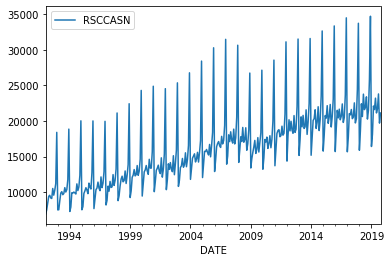

In [91]:
#Original Sales data
df.plot()

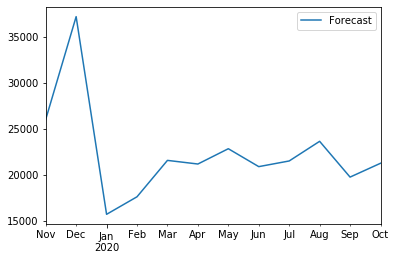

In [92]:
#My forecast
forecast_df.plot()

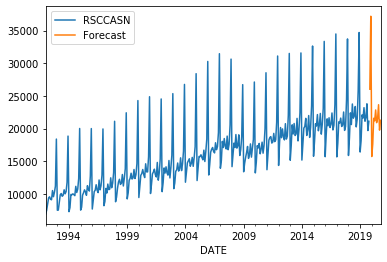

In [93]:
ax = df.plot()
forecast_df.plot(ax = ax)

(576, 611)

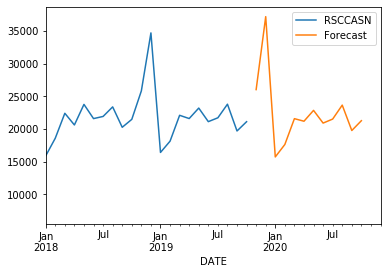

In [94]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2020-12-01')

**Nice Prediction!**